
Running experiment with SGD, lr=0.01, bs=8, shuffle=random


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
Training:   0%|          | 0/125 [00:00<?, ?it/s]`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 1/5 - Train Loss: 7.4885, Val Loss: 5.7883, Val Perplexity: 326.45


Epoch 2/5 - Train Loss: 5.1571, Val Loss: 3.6424, Val Perplexity: 38.18


Epoch 3/5 - Train Loss: 3.9583, Val Loss: 3.1428, Val Perplexity: 23.17


Epoch 4/5 - Train Loss: 3.5442, Val Loss: 2.9976, Val Perplexity: 20.04


Epoch 5/5 - Train Loss: 3.3899, Val Loss: 2.9771, Val Perplexity: 19.63


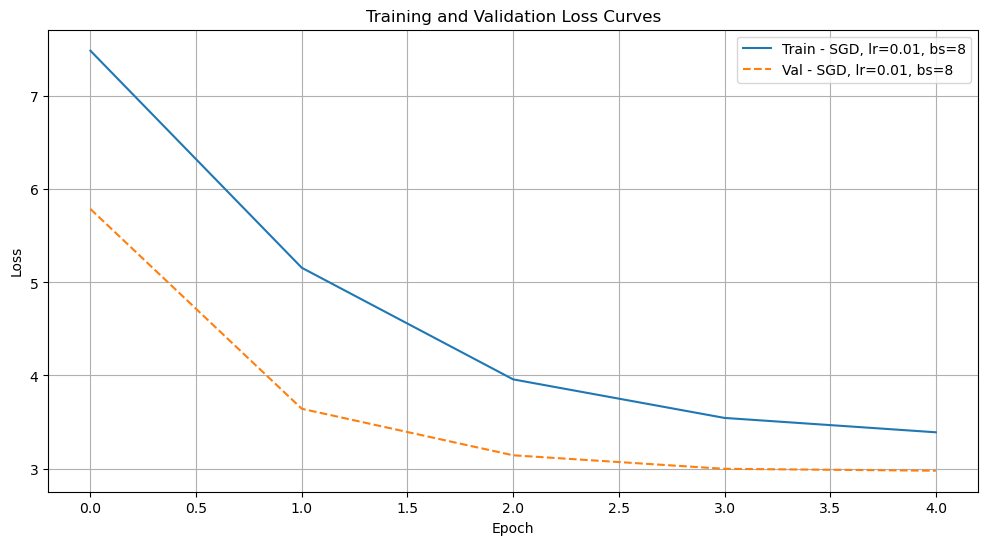

In [1]:
import torch
import numpy as np
import warnings

from optimization.experiments import run_experiment
from utils.config_loader import load_config
from utils.plots import plot_loss_curves

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*?.*")

# Load config
config = load_config("config/base.yaml")

# Device setup
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define experiments
experiments = [
    {'optimizer_class': torch.optim.SGD, 'lr': 0.01, 'batch_size': 8, 'shuffle_mode': 'random'},
    # {'optimizer_class': torch.optim.SGD, 'lr': 0.01, 'batch_size': 8, 'shuffle_mode': 'sorted'},
]

# Initialize results list
results_list = []
    
# Run experiments
for exp in experiments:
    print(f"\nRunning experiment with {exp['optimizer_class'].__name__}, lr={exp['lr']}, bs={exp['batch_size']}, shuffle={exp['shuffle_mode']}")
    results = run_experiment(config, **exp)
    results_list.append(results)

# Plot loss curves for all experiments
plot_loss_curves(results_list)
